<a href="https://colab.research.google.com/github/wantor-stack/Demand-Forecasting/blob/main/ensemble_models_1359.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Forecast for Product 1359 Demand 




In [ ]:
# install the full version
!pip install pycaret

In [ ]:
!pip install fastparquet

In [3]:
# read the parquet file
import pandas as pd

data = pd.read_parquet("stacked_df.parquet").sort_values("Date")

In [4]:
data.head()

,Warehouse,Product_Category,Product_Code,Date,Order_Demand
12782,Whse_A,Category_005,Product_0001,2012-01-01,0.0
825352,Whse_C,Category_005,Product_0469,2012-01-01,0.0
4806032,Whse_S,Category_021,Product_0337,2012-01-01,0.0
942216,Whse_C,Category_015,Product_0463,2012-01-01,0.0
4807858,Whse_S,Category_021,Product_0342,2012-01-01,0.0


In [5]:
# combine store and item column as time_series

data['Warehouse'] = ['warehouse_' + str(i) for i in data['Warehouse']]
data['Product_Code'] = ['Product_Code' + str(i) for i in data['Product_Code']]
data['time_series'] = data[['Warehouse', 'Product_Code']].apply(lambda x: '_'.join(x), axis=1)
data.drop(['Warehouse', 'Product_Category','Product_Code'], axis=1, inplace=True)

In [6]:
# extract features from date
data['day'] = [i.day for i in data['Date']]
data['month'] = [i.month for i in data['Date']]
data['year'] = [i.year for i in data['Date']]
data['day_of_week'] = [i.dayofweek for i in data['Date']]
data['day_of_year'] = [i.dayofyear for i in data['Date']]
data['week'] = [i.week for i in data['Date']]


In [7]:
data = data.sort_values(by=['time_series','Date'])

In [ ]:
# check the unique time_series
data['time_series'].unique()

array(['warehouse_Whse_A_Product_CodeProduct_0001',
       'warehouse_Whse_A_Product_CodeProduct_0020',
       'warehouse_Whse_A_Product_CodeProduct_0031', ...,
       'warehouse_Whse_S_Product_CodeProduct_2167',
       'warehouse_Whse_S_Product_CodeProduct_2168',
       'warehouse_Whse_S_Product_CodeProduct_2169'], dtype=object)

In [10]:
data_1359 = data[data['time_series'] == 'warehouse_Whse_J_Product_CodeProduct_1359']

In [11]:
data_1359

,Date,Order_Demand,time_series,day,month,year,day_of_week,day_of_year,week
3204630,2012-01-01,0.0,warehouse_Whse_J_Product_CodeProduct_1359,1,1,2012,6,1,52
3204631,2012-01-02,0.0,warehouse_Whse_J_Product_CodeProduct_1359,2,1,2012,0,2,1
3204632,2012-01-03,0.0,warehouse_Whse_J_Product_CodeProduct_1359,3,1,2012,1,3,1
3204633,2012-01-04,0.0,warehouse_Whse_J_Product_CodeProduct_1359,4,1,2012,2,4,1
3204634,2012-01-05,702000.0,warehouse_Whse_J_Product_CodeProduct_1359,5,1,2012,3,5,1
...,...,...,...,...,...,...,...,...,...
3206451,2016-12-26,286000.0,warehouse_Whse_J_Product_CodeProduct_1359,26,12,2016,0,361,52
3206452,2016-12-27,90000.0,warehouse_Whse_J_Product_CodeProduct_1359,27,12,2016,1,362,52
3206453,2016-12-28,140000.0,warehouse_Whse_J_Product_CodeProduct_1359,28,12,2016,2,363,52
3206454,2016-12-29,0.0,warehouse_Whse_J_Product_CodeProduct_1359,29,12,2016,3,364,52


In [43]:
# Split

split_year = 2015
data_train_1359 = data_1359[data_1359['year'] <= split_year]
data_val_1359 = data_1359[(data_1359['year'] > split_year) & (data_1359['month'] <= 6)]
data_test_1359 = data_1359[(data_1359['year'] > split_year) & (data_1359['month'] > 6)]
data_train_1359.shape, data_val_1359.shape, data_test_1359.shape


((1461, 9), (182, 9), (183, 9))

# 1. BASELINE

In [44]:
from pycaret.regression import *
from tqdm import tqdm

#all_ts = data['time_series'].unique()

all_results = []
final_model = {}

#for i in tqdm(all_ts):
    
df_subset = data[data['time_series'] == 'warehouse_Whse_J_Product_CodeProduct_1359']
    
# initialize setup from pycaret.regression
s = setup(data_train_1359, target = 'Order_Demand', train_size = 0.95,
          data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
          ignore_features = ['Date', 'time_series'],
          numeric_features = ['day_of_year', 'year', 'day'],
          categorical_features = ['month', 'day_of_week'],
          silent = True, verbose = False, session_id = 123)
    
# compare all models and select best one based on MAE
best_model = compare_models(sort = 'MAE', verbose=False)
    
# capture the compare result grid and store best model in list
p = pull().iloc[0:1]
p['time_series'] = str('warehouse_Whse_J_Product_CodeProduct_1359')
all_results.append(p)
    
# finalize model i.e. fit on entire data including test set
f = finalize_model(best_model)
    
# attach final model to a dictionary
final_model['warehouse_Whse_J_Product_CodeProduct_1359'] = f
    
# save transformation pipeline and model as pickle file 
save_model(f, model_name='trained_models_' + str('warehouse_Whse_J_Product_CodeProduct_1359'), verbose=False)

(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['month',
                                                             'day_of_week'],
                                       display_types=False,
                                       features_todrop=['Date', 'time_series'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['day_of_year', 'year',
                                                           'day'],
                                       target='Order_Demand',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_availabl...
                 ('dummy', Dummify(target='Order_Demand')),
                 ('fix_perfect', Remove_100(target='Order_Demand')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_se

In [45]:
concat_results = pd.concat(all_results,axis=0)
concat_results.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec),time_series
omp,Orthogonal Matching Pursuit,165075.4253,6.745670e+10,259489.8009,0.2944,4.6541,1.7779,0.0133,warehouse_Whse_J_Product_CodeProduct_1359


# 2. Feature Engineering + Best Model

In [47]:
lags = [1,4,8,16]
train1 = data_train_1359.copy()
new_features = set()
features=["Order_Demand"]

for f in features:
        for l in lags:
            new_features.add('LAG{}_{}'.format(l, f))
            train1['LAG{}_{}'.format(l, f)] = train1[f].shift(l)

            new_features.add('DIFF{}_{}'.format(l, f))
            train1['DIFF{}_{}'.format(l, f)] = train1[f].diff(l)

            new_features.add('ROLL_MEAN{}_{}'.format(l, f))
            train1['ROLL_MEAN{}_{}'.format(l, f)] = train1[f].rolling(l).mean()

            new_features.add('ROLL_MAX{}_{}'.format(l, f))
            train1['ROLL_MAX{}_{}'.format(l, f)] = train1[f].rolling(l).max()

            new_features.add('ROLL_MIN{}_{}'.format(l, f))
            train1['ROLL_MIN{}_{}'.format(l, f)] = train1[f].rolling(l).min()

            new_features.add('DELTA_ROLL_MEAN{}_{}'.format(l, f))
            train1['DELTA_ROLL_MEAN{}_{}'.format(l, f)] = train1[f] - train1[f].rolling(l).mean()

In [48]:
train1.head()

,Date,Order_Demand,time_series,day,month,year,day_of_week,day_of_year,week,LAG1_Order_Demand,DIFF1_Order_Demand,ROLL_MEAN1_Order_Demand,ROLL_MAX1_Order_Demand,ROLL_MIN1_Order_Demand,DELTA_ROLL_MEAN1_Order_Demand,LAG4_Order_Demand,DIFF4_Order_Demand,ROLL_MEAN4_Order_Demand,ROLL_MAX4_Order_Demand,ROLL_MIN4_Order_Demand,DELTA_ROLL_MEAN4_Order_Demand,LAG8_Order_Demand,DIFF8_Order_Demand,ROLL_MEAN8_Order_Demand,ROLL_MAX8_Order_Demand,ROLL_MIN8_Order_Demand,DELTA_ROLL_MEAN8_Order_Demand,LAG16_Order_Demand,DIFF16_Order_Demand,ROLL_MEAN16_Order_Demand,ROLL_MAX16_Order_Demand,ROLL_MIN16_Order_Demand,DELTA_ROLL_MEAN16_Order_Demand
3204630,2012-01-01,0.0,warehouse_Whse_J_Product_CodeProduct_1359,1,1,2012,6,1,52,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3204631,2012-01-02,0.0,warehouse_Whse_J_Product_CodeProduct_1359,2,1,2012,0,2,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3204632,2012-01-03,0.0,warehouse_Whse_J_Product_CodeProduct_1359,3,1,2012,1,3,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3204633,2012-01-04,0.0,warehouse_Whse_J_Product_CodeProduct_1359,4,1,2012,2,4,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3204634,2012-01-05,702000.0,warehouse_Whse_J_Product_CodeProduct_1359,5,1,2012,3,5,1,0.0,702000.0,702000.0,702000.0,702000.0,0.0,0.0,702000.0,175500.0,702000.0,0.0,526500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
train1 = train1.fillna(-1)

In [50]:
new_features

{'DELTA_ROLL_MEAN16_Order_Demand',
 'DELTA_ROLL_MEAN1_Order_Demand',
 'DELTA_ROLL_MEAN4_Order_Demand',
 'DELTA_ROLL_MEAN8_Order_Demand',
 'DIFF16_Order_Demand',
 'DIFF1_Order_Demand',
 'DIFF4_Order_Demand',
 'DIFF8_Order_Demand',
 'LAG16_Order_Demand',
 'LAG1_Order_Demand',
 'LAG4_Order_Demand',
 'LAG8_Order_Demand',
 'ROLL_MAX16_Order_Demand',
 'ROLL_MAX1_Order_Demand',
 'ROLL_MAX4_Order_Demand',
 'ROLL_MAX8_Order_Demand',
 'ROLL_MEAN16_Order_Demand',
 'ROLL_MEAN1_Order_Demand',
 'ROLL_MEAN4_Order_Demand',
 'ROLL_MEAN8_Order_Demand',
 'ROLL_MIN16_Order_Demand',
 'ROLL_MIN1_Order_Demand',
 'ROLL_MIN4_Order_Demand',
 'ROLL_MIN8_Order_Demand'}

In [51]:
train1.columns

Index(['Date', 'Order_Demand', 'time_series', 'day', 'month', 'year',
       'day_of_week', 'day_of_year', 'week', 'LAG1_Order_Demand',
       'DIFF1_Order_Demand', 'ROLL_MEAN1_Order_Demand',
       'ROLL_MAX1_Order_Demand', 'ROLL_MIN1_Order_Demand',
       'DELTA_ROLL_MEAN1_Order_Demand', 'LAG4_Order_Demand',
       'DIFF4_Order_Demand', 'ROLL_MEAN4_Order_Demand',
       'ROLL_MAX4_Order_Demand', 'ROLL_MIN4_Order_Demand',
       'DELTA_ROLL_MEAN4_Order_Demand', 'LAG8_Order_Demand',
       'DIFF8_Order_Demand', 'ROLL_MEAN8_Order_Demand',
       'ROLL_MAX8_Order_Demand', 'ROLL_MIN8_Order_Demand',
       'DELTA_ROLL_MEAN8_Order_Demand', 'LAG16_Order_Demand',
       'DIFF16_Order_Demand', 'ROLL_MEAN16_Order_Demand',
       'ROLL_MAX16_Order_Demand', 'ROLL_MIN16_Order_Demand',
       'DELTA_ROLL_MEAN16_Order_Demand'],
      dtype='object')

In [52]:
from pycaret.regression import *
exp_reg101 = setup(train1, target = 'Order_Demand', train_size = 0.80,
              data_split_shuffle = False,
              ignore_features = ['Date','time_series'],
              numeric_features = ['day_of_year', 'year'] + list(new_features),
              categorical_features = ['month', 'day_of_week', 'day','week'],
              silent = True, verbose = False, session_id = 123)

In [53]:
best = compare_models(exclude = ['ransac'], sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,0.3580,3.132000e-01,0.4926,1.0000,0.1733,0.0000,0.013
lasso,Lasso Regression,1.1629,4.239600e+00,1.5102,1.0000,0.4077,0.0000,0.015
en,Elastic Net,1.5997,4.322200e+00,2.0439,1.0000,0.5439,0.0000,0.013
llar,Lasso Least Angle Regression,24.8834,1.059173e+03,32.2558,1.0000,1.9464,0.0002,0.203
lr,Linear Regression,899.1271,2.015731e+08,4489.8795,0.9972,0.1143,0.0022,0.013
par,Passive Aggressive Regressor,910.8566,2.056877e+08,4535.5102,0.9972,0.1343,0.0023,0.022
huber,Huber Regressor,911.1331,2.056877e+08,4535.8643,0.9972,0.2445,0.0023,0.041
ridge,Ridge Regression,1006.6451,2.430428e+08,4930.1100,0.9966,0.1043,0.0026,0.014
br,Bayesian Ridge,1717.4701,2.114268e+08,5619.4129,0.9971,1.6573,0.0067,0.039
rf,Random Forest Regressor,1859.0686,1.203728e+08,8057.1612,0.9989,0.1048,0.0097,0.541


In [54]:
tuned_model = tune_model(best)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1503,0.1503,0.3876,1.0,0.2063,0.0
1,0.2231,0.0811,0.2849,1.0,0.1218,0.0
2,0.1730,0.0460,0.2145,1.0,0.0990,0.0
3,0.3396,0.2223,0.4715,1.0,0.1679,0.0
4,0.1531,0.0345,0.1857,1.0,0.0969,0.0
5,0.1349,0.0263,0.1622,1.0,0.0906,0.0
6,0.0502,0.0044,0.0664,1.0,0.0364,0.0
7,0.0426,0.0037,0.0607,1.0,0.0350,0.0
8,0.1408,0.0364,0.1907,1.0,0.0980,0.0
9,0.3396,0.1735,0.4166,1.0,0.1837,0.0


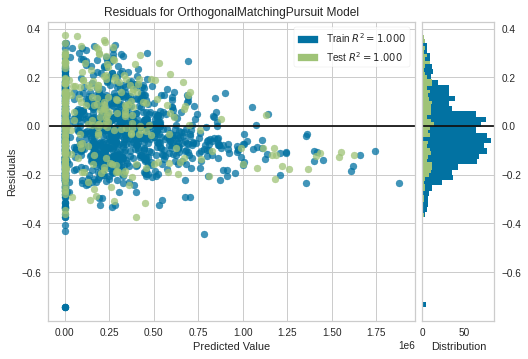

In [55]:
plot_model(tuned_model)

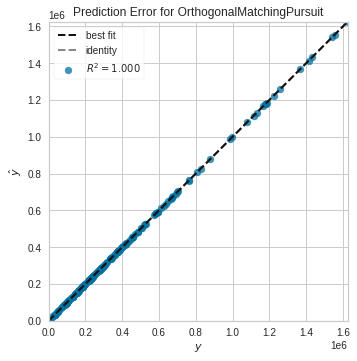

In [56]:
plot_model(tuned_model, plot = 'error')

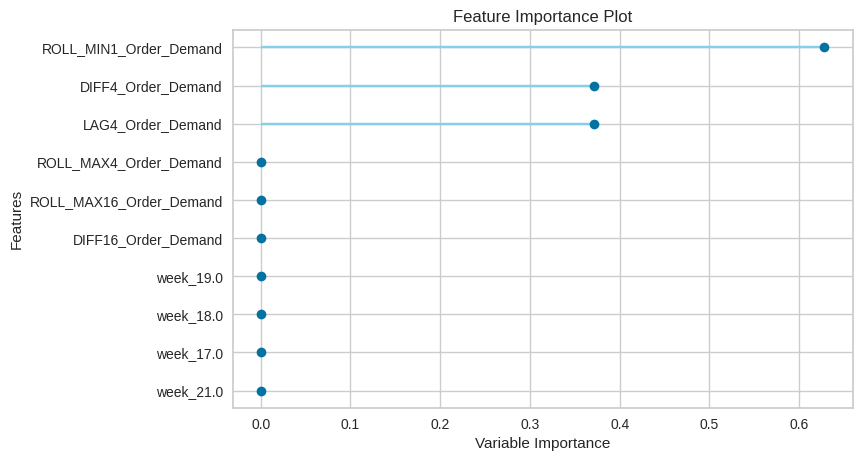

In [57]:
plot_model(tuned_model, plot='feature')

In [58]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# 3. Feature Engineering + Random Forest Regressor

In [60]:
lags = [2,4,7,15,30,60]
train2 = data_train_1359.copy()
new_features2 = set()
features=["Order_Demand"]

for f in features:
        for l in lags:
            new_features.add('LAG{}_{}'.format(l, f))
            train2['LAG{}_{}'.format(l, f)] = train2[f].shift(l)

            new_features.add('DIFF{}_{}'.format(l, f))
            train2['DIFF{}_{}'.format(l, f)] = train2[f].diff(l)

            new_features.add('ROLL_MEAN{}_{}'.format(l, f))
            train2['ROLL_MEAN{}_{}'.format(l, f)] = train2[f].rolling(l).mean()

            new_features.add('ROLL_MAX{}_{}'.format(l, f))
            train2['ROLL_MAX{}_{}'.format(l, f)] = train2[f].rolling(l).max()

            new_features.add('ROLL_MIN{}_{}'.format(l, f))
            train2['ROLL_MIN{}_{}'.format(l, f)] = train2[f].rolling(l).min()

            new_features.add('DELTA_ROLL_MEAN{}_{}'.format(l, f))
            train2['DELTA_ROLL_MEAN{}_{}'.format(l, f)] = train2[f] - train2[f].rolling(l).mean()

In [61]:
train2 = train2.fillna(-1)

In [62]:
train2

,Date,Order_Demand,time_series,day,month,year,day_of_week,day_of_year,week,LAG2_Order_Demand,DIFF2_Order_Demand,ROLL_MEAN2_Order_Demand,ROLL_MAX2_Order_Demand,ROLL_MIN2_Order_Demand,DELTA_ROLL_MEAN2_Order_Demand,LAG4_Order_Demand,DIFF4_Order_Demand,ROLL_MEAN4_Order_Demand,ROLL_MAX4_Order_Demand,ROLL_MIN4_Order_Demand,DELTA_ROLL_MEAN4_Order_Demand,LAG7_Order_Demand,DIFF7_Order_Demand,ROLL_MEAN7_Order_Demand,ROLL_MAX7_Order_Demand,ROLL_MIN7_Order_Demand,DELTA_ROLL_MEAN7_Order_Demand,LAG15_Order_Demand,DIFF15_Order_Demand,ROLL_MEAN15_Order_Demand,ROLL_MAX15_Order_Demand,ROLL_MIN15_Order_Demand,DELTA_ROLL_MEAN15_Order_Demand,LAG30_Order_Demand,DIFF30_Order_Demand,ROLL_MEAN30_Order_Demand,ROLL_MAX30_Order_Demand,ROLL_MIN30_Order_Demand,DELTA_ROLL_MEAN30_Order_Demand,LAG60_Order_Demand,DIFF60_Order_Demand,ROLL_MEAN60_Order_Demand,ROLL_MAX60_Order_Demand,ROLL_MIN60_Order_Demand,DELTA_ROLL_MEAN60_Order_Demand
3204630,2012-01-01,0.0,warehouse_Whse_J_Product_CodeProduct_1359,1,1,2012,6,1,52,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000
3204631,2012-01-02,0.0,warehouse_Whse_J_Product_CodeProduct_1359,2,1,2012,0,2,1,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000
3204632,2012-01-03,0.0,warehouse_Whse_J_Product_CodeProduct_1359,3,1,2012,1,3,1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000
3204633,2012-01-04,0.0,warehouse_Whse_J_Product_CodeProduct_1359,4,1,2012,2,4,1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000
3204634,2012-01-05,702000.0,warehouse_Whse_J_Product_CodeProduct_1359,5,1,2012,3,5,1,0.0,702000.0,351000.0,702000.0,0.0,351000.0,0.0,702000.0,175500.0,702000.0,0.0,526500.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3206086,2015-12-27,0.0,warehouse_Whse_J_Product_CodeProduct_1359,27,12,2015,6,361,52,98000.0,-98000.0,0.0,0.0,0.0,0.0,0.0,0.0,81750.0,229000.0,0.0,-81750.0,0.0,0.0,112000.000000,236000.0,0.0,-112000.000000,0.0,0.0,218800.000000,1433000.0,0.0,-218800.000000,272000.0,-272000.0,216300.000000,1433000.0,0.0,-216300.000000,301000.0,-301000.0,234916.666667,1542000.0,0.0,-234916.666667
3206087,2015-12-28,507000.0,warehouse_Whse_J_Product_CodeProduct_1359,28,12,2015,0,362,53,0.0,507000.0,253500.0,507000.0,0.0,253500.0,229000.0,278000.0,151250.0,507000.0,0.0,355750.0,221000.0,286000.0,152857.142857,507000.0,0.0,354142.857143,0.0,507000.0,252600.000000,1433000.0,0.0,254400.000000,0.0,507000.0,233200.000000,1433000.0,0.0,273800.000000,132000.0,375000.0,241166.666667,1542000.0,0.0,265833.333333
3206088,2015-12-29,0.0,warehouse_Whse_J_Product_CodeProduct_1359,29,12,2015,1,363,53,0.0,0.0,253500.0,507000.0,0.0,-253500.0,98000.0,-98000.0,126750.0,507000.0,0.0,-126750.0,236000.0,-236000.0,119142.857143,507000.0,0.0,-119142.857143,166000.0,-166000.0,241533.333333,1433000.0,0.0,-241533.333333,0.0,0.0,233200.000000,1433000.0,0.0,-233200.000000,451000.0,-451000.0,233650.000000,1542000.0,0.0,-233650.000000
3206089,2015-12-30,0.0,warehouse_Whse_J_Product_CodeProduct_1359,30,12,2015,2,364,53,507000.0,-507000.0,0.0,0.0,0.0,0.0,0.0,0.0,126750.0,507000.0,0.0,-126750.0,0.0,0.0,119142.857143,50

In [63]:
#from pycaret.regression import *
exp_reg101 = setup(train2, target = 'Order_Demand', train_size = 0.80,
              data_split_shuffle = False,
              ignore_features = ['Date','time_series'],
              numeric_features = ['day_of_year', 'year'] + list(new_features2),
              categorical_features = ['month', 'day_of_week', 'day','week'],
              silent = True, verbose = False, session_id = 123)

In [64]:
rf = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,120669.3162,4.662533e+10,215928.9852,0.3543,5.2374,0.3096
1,7428.7179,2.019829e+08,14212.0672,0.9958,2.1466,0.5941
2,7951.0256,2.352929e+08,15339.2609,0.9970,1.1012,0.0432
3,12421.9658,8.930165e+08,29883.3817,0.9925,0.8178,0.0534
4,3569.9145,4.267094e+07,6532.2996,0.9994,0.0277,0.0183
5,8301.2821,2.428303e+08,15583.0123,0.9980,0.1426,0.0589
6,8527.0940,1.891616e+08,13753.6044,0.9980,1.4215,0.0407
7,4947.4359,6.559957e+07,8099.3563,0.9991,0.5560,0.0302
8,7101.7241,1.489633e+08,12205.0510,0.9984,0.8986,0.0604
9,6599.0517,2.924428e+08,17100.9596,0.9966,0.5787,0.0300


In [65]:
tuned_rf = tune_model(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,54746.6142,8.145271e+09,90251.1532,0.8872,5.5151,0.1687
1,13726.4873,4.392130e+08,20957.4090,0.9909,4.4714,0.4613
2,11035.6470,2.600644e+08,16126.5111,0.9967,4.3704,0.0686
3,18034.5472,1.570352e+09,39627.6620,0.9868,5.1031,0.0604
4,11548.3616,2.910116e+08,17059.0635,0.9960,4.6082,0.0550
5,15136.1431,6.056043e+08,24609.0297,0.9949,4.6511,0.1243
6,17141.5225,7.195859e+08,26825.0981,0.9924,5.2149,0.0614
7,11028.4863,2.761633e+08,16618.1623,0.9962,4.5244,0.0555
8,13970.8232,3.520845e+08,18763.9149,0.9962,4.7999,0.2144
9,14137.3326,6.999969e+08,26457.4540,0.9918,4.9967,0.0741


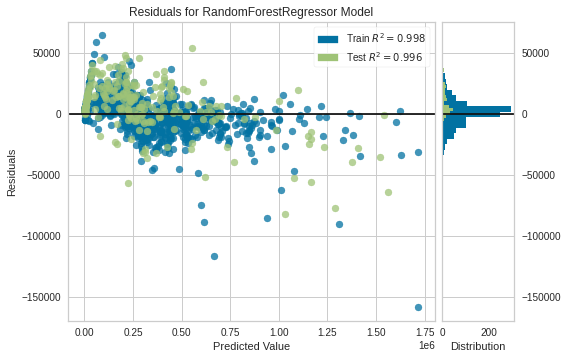

In [66]:
plot_model(tuned_rf)

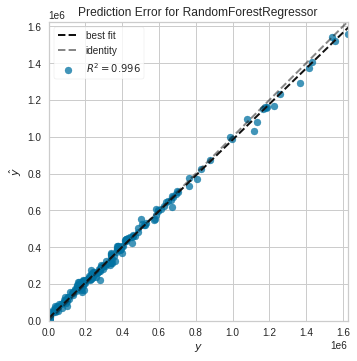

In [67]:
plot_model(tuned_rf, plot = 'error')

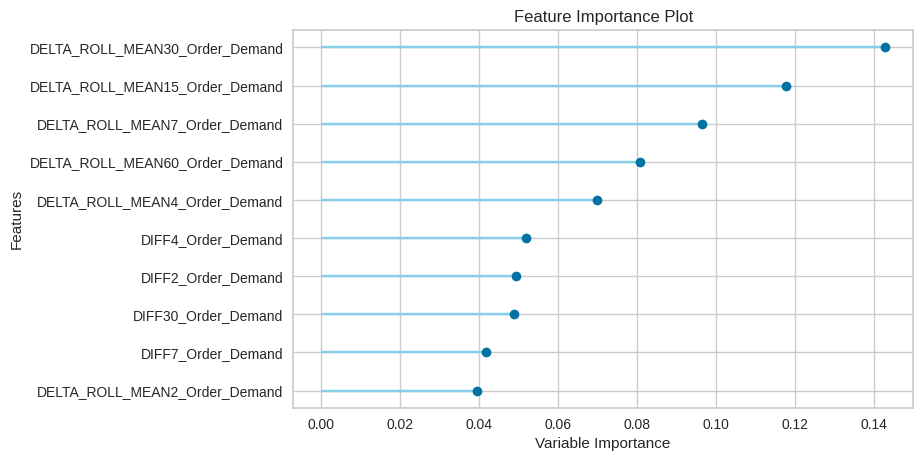

In [68]:
plot_model(tuned_rf, plot='feature')

In [69]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## 3.1 Predict on Test / Hold-out Sample

Before finalizing the model, it is advisable to perform one final check by predicting the test/hold-out set and reviewing the evaluation metrics. If you look at the information grid in Section 6 above, you will see that 30% (1621 samples) of the data has been separated out as a test/hold-out sample. All of the evaluation metrics we have seen above are cross-validated results based on training set (70%) only. Now, using our final trained model stored in the tuned_rf variable we will predict the hold-out sample and evaluate the metrics to see if they are materially different than the CV results.

In [70]:
predict_model(tuned_rf);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,14311.6828,3.982547e+08,19956.3195,0.9962,4.8641,0.1753


## 3.2 Finalize Model for Deployment

In [71]:
final_rf = finalize_model(tuned_rf)

In [72]:
print(final_rf)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0001,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=240, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)


In [73]:
predict_model(final_rf);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,7652.3635,1.124013e+08,10601.9488,0.9989,4.6388,0.0972


## 3.3 Predict on Unseen Data

In [74]:
lags = [2,4,7,15,30,60]
val2 = data_val_1359.copy()
new_features2 = set()
features=["Order_Demand"]

for f in features:
        for l in lags:
            new_features.add('LAG{}_{}'.format(l, f))
            val2['LAG{}_{}'.format(l, f)] = val2[f].shift(l)

            new_features.add('DIFF{}_{}'.format(l, f))
            val2['DIFF{}_{}'.format(l, f)] = val2[f].diff(l)

            new_features.add('ROLL_MEAN{}_{}'.format(l, f))
            val2['ROLL_MEAN{}_{}'.format(l, f)] = val2[f].rolling(l).mean()

            new_features.add('ROLL_MAX{}_{}'.format(l, f))
            val2['ROLL_MAX{}_{}'.format(l, f)] = val2[f].rolling(l).max()

            new_features.add('ROLL_MIN{}_{}'.format(l, f))
            val2['ROLL_MIN{}_{}'.format(l, f)] = val2[f].rolling(l).min()

            new_features.add('DELTA_ROLL_MEAN{}_{}'.format(l, f))
            val2['DELTA_ROLL_MEAN{}_{}'.format(l, f)] = val2[f] - val2[f].rolling(l).mean()

In [75]:
val2 = val2.fillna(-1)

In [76]:
unseen_predictions = predict_model(final_rf, data=val2)
unseen_predictions.head()

,Date,Order_Demand,time_series,day,month,year,day_of_week,day_of_year,week,LAG2_Order_Demand,DIFF2_Order_Demand,ROLL_MEAN2_Order_Demand,ROLL_MAX2_Order_Demand,ROLL_MIN2_Order_Demand,DELTA_ROLL_MEAN2_Order_Demand,LAG4_Order_Demand,DIFF4_Order_Demand,ROLL_MEAN4_Order_Demand,ROLL_MAX4_Order_Demand,ROLL_MIN4_Order_Demand,DELTA_ROLL_MEAN4_Order_Demand,LAG7_Order_Demand,DIFF7_Order_Demand,ROLL_MEAN7_Order_Demand,ROLL_MAX7_Order_Demand,ROLL_MIN7_Order_Demand,DELTA_ROLL_MEAN7_Order_Demand,LAG15_Order_Demand,DIFF15_Order_Demand,ROLL_MEAN15_Order_Demand,ROLL_MAX15_Order_Demand,ROLL_MIN15_Order_Demand,DELTA_ROLL_MEAN15_Order_Demand,LAG30_Order_Demand,DIFF30_Order_Demand,ROLL_MEAN30_Order_Demand,ROLL_MAX30_Order_Demand,ROLL_MIN30_Order_Demand,DELTA_ROLL_MEAN30_Order_Demand,LAG60_Order_Demand,DIFF60_Order_Demand,ROLL_MEAN60_Order_Demand,ROLL_MAX60_Order_Demand,ROLL_MIN60_Order_Demand,DELTA_ROLL_MEAN60_Order_Demand,Label
3206091,2016-01-01,0.0,warehouse_Whse_J_Product_CodeProduct_1359,1,1,2016,4,1,53,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,19371.654946
3206092,2016-01-02,0.0,warehouse_Whse_J_Product_CodeProduct_1359,2,1,2016,5,2,53,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,11277.404397
3206093,2016-01-03,0.0,warehouse_Whse_J_Product_CodeProduct_1359,3,1,2016,6,3,53,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,12513.757238
3206094,2016-01-04,0.0,warehouse_Whse_J_Product_CodeProduct_1359,4,1,2016,0,4,1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,20274.983927
3206095,2016-01-05,479000.0,warehouse_Whse_J_Product_CodeProduct_1359,5,1,2016,1,5,1,0.0,479000.0,239500.0,479000.0,0.0,239500.0,0.0,479000.0,119750.0,479000.0,0.0,359250.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,491139.485643


In [77]:
from pycaret.utils import check_metric
print(check_metric(unseen_predictions.Order_Demand, unseen_predictions.Label, 'R2'))
print(check_metric(unseen_predictions.Order_Demand, unseen_predictions.Label, 'MAE'))

0.9873
20566.0777


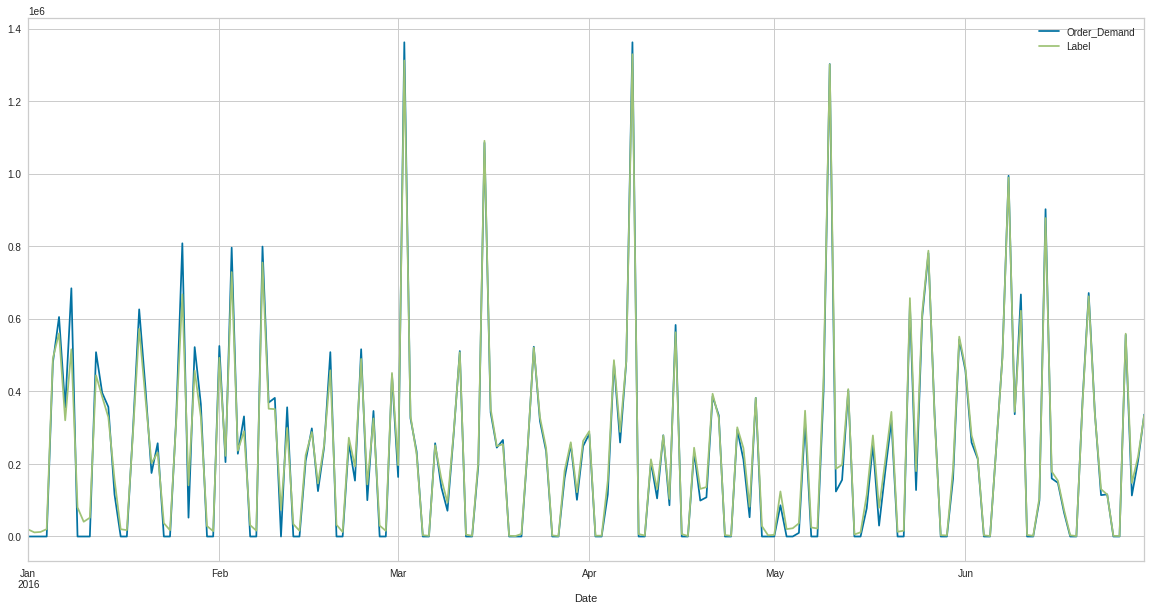

In [78]:
unseen_predictions.plot(x='Date', y=['Order_Demand', 'Label'], figsize=(20,10), grid=True)

## 3.4 Saving the Model

In [79]:
save_model(final_rf,'Final Random Forest Model 1359 28 Jun 2021')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['month',
                                                             'day_of_week',
                                                             'day', 'week'],
                                       display_types=False,
                                       features_todrop=['Date', 'time_series'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['day_of_year',
                                                           'year'],
                                       target='Order_Demand',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_a...
                  RandomForestRegressor(bootstrap=False, ccp_alpha=0.0,
                                        criterion='mse', max_depth=8,
         

## 3.5 Loading the Saved Model

In [80]:
lags = [2,4,7,15,30, 60]
test2 = data_test_1359.copy()
new_features3 = set()
features=["Order_Demand"]

for f in features:
        for l in lags:
            new_features.add('LAG{}_{}'.format(l, f))
            test2['LAG{}_{}'.format(l, f)] = test2[f].shift(l)

            new_features.add('DIFF{}_{}'.format(l, f))
            test2['DIFF{}_{}'.format(l, f)] = test2[f].diff(l)

            new_features.add('ROLL_MEAN{}_{}'.format(l, f))
            test2['ROLL_MEAN{}_{}'.format(l, f)] = test2[f].rolling(l).mean()

            new_features.add('ROLL_MAX{}_{}'.format(l, f))
            test2['ROLL_MAX{}_{}'.format(l, f)] = test2[f].rolling(l).max()

            new_features.add('ROLL_MIN{}_{}'.format(l, f))
            test2['ROLL_MIN{}_{}'.format(l, f)] = test2[f].rolling(l).min()

            new_features.add('DELTA_ROLL_MEAN{}_{}'.format(l, f))
            test2['DELTA_ROLL_MEAN{}_{}'.format(l, f)] = test2[f] - test2[f].rolling(l).mean()

In [81]:
test2 = test2.fillna(-1)

In [82]:
saved_final_rf = load_model('Final Random Forest Model 1359 28 Jun 2021')

Transformation Pipeline and Model Successfully Loaded


In [83]:
new_prediction = predict_model(saved_final_rf, data=test2)

In [84]:
new_prediction.head()

,Date,Order_Demand,time_series,day,month,year,day_of_week,day_of_year,week,LAG2_Order_Demand,DIFF2_Order_Demand,ROLL_MEAN2_Order_Demand,ROLL_MAX2_Order_Demand,ROLL_MIN2_Order_Demand,DELTA_ROLL_MEAN2_Order_Demand,LAG4_Order_Demand,DIFF4_Order_Demand,ROLL_MEAN4_Order_Demand,ROLL_MAX4_Order_Demand,ROLL_MIN4_Order_Demand,DELTA_ROLL_MEAN4_Order_Demand,LAG7_Order_Demand,DIFF7_Order_Demand,ROLL_MEAN7_Order_Demand,ROLL_MAX7_Order_Demand,ROLL_MIN7_Order_Demand,DELTA_ROLL_MEAN7_Order_Demand,LAG15_Order_Demand,DIFF15_Order_Demand,ROLL_MEAN15_Order_Demand,ROLL_MAX15_Order_Demand,ROLL_MIN15_Order_Demand,DELTA_ROLL_MEAN15_Order_Demand,LAG30_Order_Demand,DIFF30_Order_Demand,ROLL_MEAN30_Order_Demand,ROLL_MAX30_Order_Demand,ROLL_MIN30_Order_Demand,DELTA_ROLL_MEAN30_Order_Demand,LAG60_Order_Demand,DIFF60_Order_Demand,ROLL_MEAN60_Order_Demand,ROLL_MAX60_Order_Demand,ROLL_MIN60_Order_Demand,DELTA_ROLL_MEAN60_Order_Demand,Label
3206273,2016-07-01,700000.0,warehouse_Whse_J_Product_CodeProduct_1359,1,7,2016,4,183,26,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,39355.109731
3206274,2016-07-02,0.0,warehouse_Whse_J_Product_CodeProduct_1359,2,7,2016,5,184,26,-1.0,-1.0,350000.0,700000.0,0.0,-350000.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,105767.501335
3206275,2016-07-03,0.0,warehouse_Whse_J_Product_CodeProduct_1359,3,7,2016,6,185,26,700000.0,-700000.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,36606.909885
3206276,2016-07-04,619000.0,warehouse_Whse_J_Product_CodeProduct_1359,4,7,2016,0,186,27,0.0,619000.0,309500.0,619000.0,0.0,309500.0,-1.0,-1.0,329750.0,700000.0,0.0,289250.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,468551.028133
3206277,2016-07-05,1115000.0,warehouse_Whse_J_Product_CodeProduct_1359,5,7,2016,1,187,27,0.0,1115000.0,867000.0,1115000.0,619000.0,248000.0,700000.0,415000.0,433500.0,1115000.0,0.0,681500.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,601498.956822


In [85]:
from pycaret.utils import check_metric
print(check_metric(new_prediction.Order_Demand, new_prediction.Label, 'R2'))
print(check_metric(new_prediction.Order_Demand, new_prediction.Label, 'MAE'))

0.9263
30886.7338


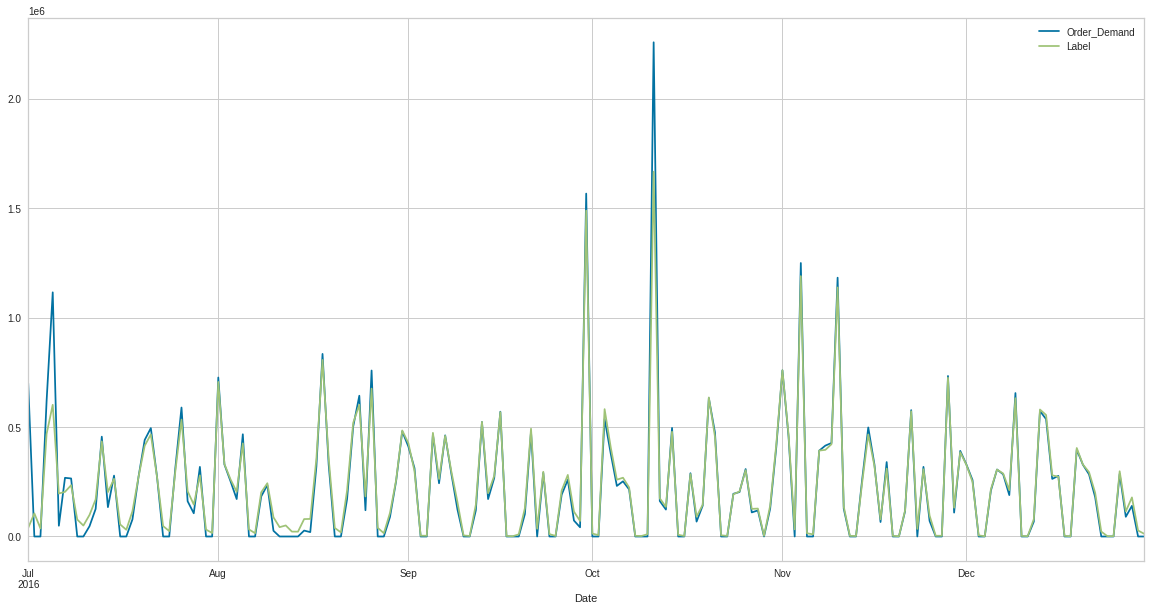

In [86]:
new_prediction.plot(x='Date', y=['Order_Demand', 'Label'], figsize=(20,10), grid=True)


# 4. ENSEMBLE DE MODELOS

In [87]:
exp_reg102 = setup(data = train2, target = 'Order_Demand', session_id=123,
                  #normalize = True, 
                  #transformation = True, 
                  #transform_target = True, 
                  combine_rare_levels = True, rare_level_threshold = 0.05,
                  #remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                  ignore_features = ['Date'],
                  numeric_features = ['day_of_year', 'year'] + list(new_features2),
                  categorical_features = ['month', 'day_of_week', 'day'],
                  silent = True, verbose = False)

In [88]:
top3 = compare_models(exclude = ['ransac'], n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,1.267300e+00,9.368890e+01,4.809200e+00,1.000000e+00,0.3508,0.000000e+00,0.014
en,Elastic Net,1.721700e+00,1.847232e+02,7.256400e+00,1.000000e+00,0.4495,0.000000e+00,0.014
omp,Orthogonal Matching Pursuit,2.730000e-01,1.320800e+00,8.274000e-01,1.000000e+00,0.1757,0.000000e+00,0.011
ridge,Ridge Regression,1.520201e+02,1.515196e+07,1.533839e+03,9.998000e-01,0.1125,4.000000e-04,0.012
lr,Linear Regression,1.588134e+02,2.553608e+07,1.602151e+03,9.997000e-01,0.1272,3.000000e-04,0.206
br,Bayesian Ridge,1.392293e+03,5.742127e+07,3.676979e+03,9.995000e-01,1.6873,5.600000e-03,0.025
par,Passive Aggressive Regressor,2.310194e+02,4.576179e+07,2.197836e+03,9.995000e-01,1.0820,5.000000e-04,0.019
et,Extra Trees Regressor,7.659509e+03,4.176531e+08,1.968508e+04,9.951000e-01,2.2744,6.830000e-02,0.443
llar,Lasso Least Angle Regression,7.321471e+02,4.828335e+08,7.022339e+03,9.951000e-01,2.0616,1.800000e-03,0.011
huber,Huber Regressor,2.695055e+03,4.969334e+08,1.828272e+04,9.941000e-01,2.5220,9.100000e-03,0.030


In [95]:
# train individual models to blend
lightgbm = create_model('lightgbm', verbose = False)
knn = create_model('knn', verbose = False)
lr = create_model('lr', verbose = False)

In [96]:
blender = blend_models(estimator_list = [lightgbm, knn, lr])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,14149.9198,6.001700e+08,24498.3672,0.9958,3.7898,0.0638
1,16866.0163,1.153968e+09,33970.1049,0.9836,4.1942,0.0788
2,16269.6801,1.615805e+09,40197.0756,0.9836,4.2940,0.1468
3,15406.4113,1.048702e+09,32383.6631,0.9902,3.9683,0.0893
4,15824.7211,5.568225e+08,23597.0872,0.9921,3.9685,0.2290
5,10228.8648,2.431408e+08,15592.9726,0.9964,3.6970,0.0801
6,18885.3910,1.297004e+09,36013.9471,0.9796,3.2229,0.1749
7,14276.2649,5.076858e+08,22531.8834,0.9925,3.8350,0.0935
8,13161.8851,4.472523e+08,21148.3414,0.9958,4.2426,0.1041
9,11332.3192,5.154867e+08,22704.3322,0.9954,4.3919,0.0530


In [98]:
blender_tuned = tune_model(blender)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,10255.6327,3.105078e+08,17621.2328,0.9978,3.5394,0.0472
1,12219.7680,5.741510e+08,23961.4479,0.9919,3.9790,0.0576
2,12228.2437,1.055055e+09,32481.6059,0.9893,4.0796,0.1104
3,11163.3448,5.243353e+08,22898.3679,0.9951,3.7533,0.0660
4,11689.9037,3.031969e+08,17412.5491,0.9957,3.7491,0.1697
5,7543.4582,1.306677e+08,11430.9974,0.9981,3.4582,0.0591
6,13680.6129,6.389823e+08,25278.0994,0.9899,3.0532,0.1171
7,10455.1199,2.644223e+08,16261.0667,0.9961,3.6250,0.0691
8,9582.3787,2.289063e+08,15129.6510,0.9978,3.9945,0.0748
9,8127.6605,2.584555e+08,16076.5501,0.9977,4.1604,0.0388


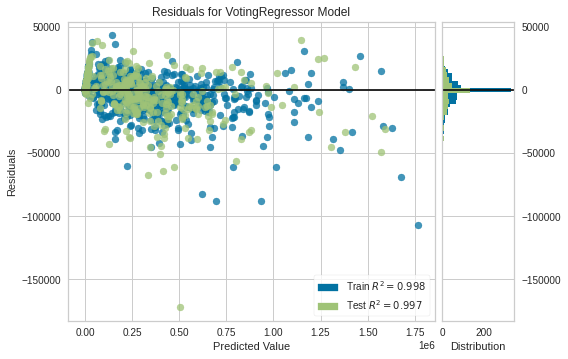

In [116]:
plot_model(blender_tuned)

In [104]:
plot_model(blender_tuned, plot = 'residuals_interactive')

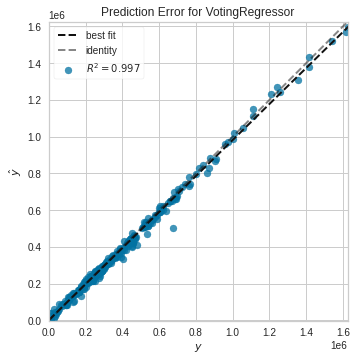

In [105]:
plot_model(blender_tuned, plot = 'error')

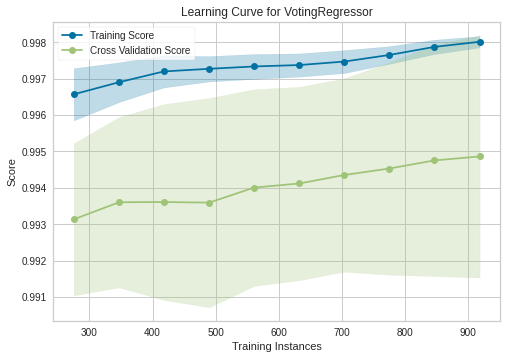

In [109]:
plot_model(blender_tuned, plot = 'learning')

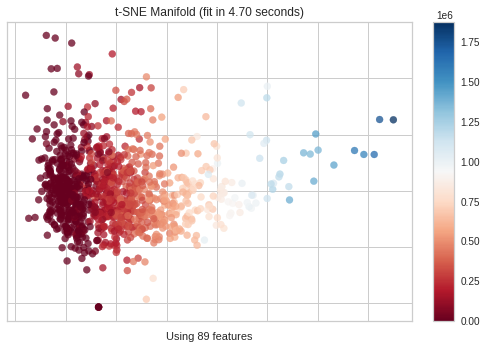

In [111]:
plot_model(blender_tuned, plot = 'manifold')

 ## 4.1 Predict on Test / Hold-out Sample

In [117]:
predict_model(blender_tuned);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,10484.1671,3.010755e+08,17351.5273,0.9966,3.6623,0.0905


## 4.2 Finalize Model for Deployment

In [118]:
final_voting = finalize_model(blender_tuned)

In [119]:
print(final_voting)

VotingRegressor(estimators=[('lightgbm',
                             LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=123,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silent=True, subs...,
                                           subsample_for_bin=200000,
                                           subsample_fre

In [120]:
predict_model(final_voting);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,7235.1531,1.269632e+08,11267.7948,0.9986,3.3375,0.0503


## 4.3 Predict on Unseen Data

In [121]:
unseen_predictions_voting = predict_model(final_voting, data=val2)
unseen_predictions_voting.head()

,Date,Order_Demand,time_series,day,month,year,day_of_week,day_of_year,week,LAG2_Order_Demand,DIFF2_Order_Demand,ROLL_MEAN2_Order_Demand,ROLL_MAX2_Order_Demand,ROLL_MIN2_Order_Demand,DELTA_ROLL_MEAN2_Order_Demand,LAG4_Order_Demand,DIFF4_Order_Demand,ROLL_MEAN4_Order_Demand,ROLL_MAX4_Order_Demand,ROLL_MIN4_Order_Demand,DELTA_ROLL_MEAN4_Order_Demand,LAG7_Order_Demand,DIFF7_Order_Demand,ROLL_MEAN7_Order_Demand,ROLL_MAX7_Order_Demand,ROLL_MIN7_Order_Demand,DELTA_ROLL_MEAN7_Order_Demand,LAG15_Order_Demand,DIFF15_Order_Demand,ROLL_MEAN15_Order_Demand,ROLL_MAX15_Order_Demand,ROLL_MIN15_Order_Demand,DELTA_ROLL_MEAN15_Order_Demand,LAG30_Order_Demand,DIFF30_Order_Demand,ROLL_MEAN30_Order_Demand,ROLL_MAX30_Order_Demand,ROLL_MIN30_Order_Demand,DELTA_ROLL_MEAN30_Order_Demand,LAG60_Order_Demand,DIFF60_Order_Demand,ROLL_MEAN60_Order_Demand,ROLL_MAX60_Order_Demand,ROLL_MIN60_Order_Demand,DELTA_ROLL_MEAN60_Order_Demand,Label
3206091,2016-01-01,0.0,warehouse_Whse_J_Product_CodeProduct_1359,1,1,2016,4,1,53,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8486.188294
3206092,2016-01-02,0.0,warehouse_Whse_J_Product_CodeProduct_1359,2,1,2016,5,2,53,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8486.533655
3206093,2016-01-03,0.0,warehouse_Whse_J_Product_CodeProduct_1359,3,1,2016,6,3,53,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8486.801299
3206094,2016-01-04,0.0,warehouse_Whse_J_Product_CodeProduct_1359,4,1,2016,0,4,1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8461.498984
3206095,2016-01-05,479000.0,warehouse_Whse_J_Product_CodeProduct_1359,5,1,2016,1,5,1,0.0,479000.0,239500.0,479000.0,0.0,239500.0,0.0,479000.0,119750.0,479000.0,0.0,359250.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,430354.900360


In [124]:
# Metrics
from pycaret.utils import check_metric
print(check_metric(unseen_predictions_voting.Order_Demand, unseen_predictions_voting.Label, 'R2'))
print(check_metric(unseen_predictions_voting.Order_Demand, unseen_predictions_voting.Label, 'MAE'))

0.9939
12205.0227


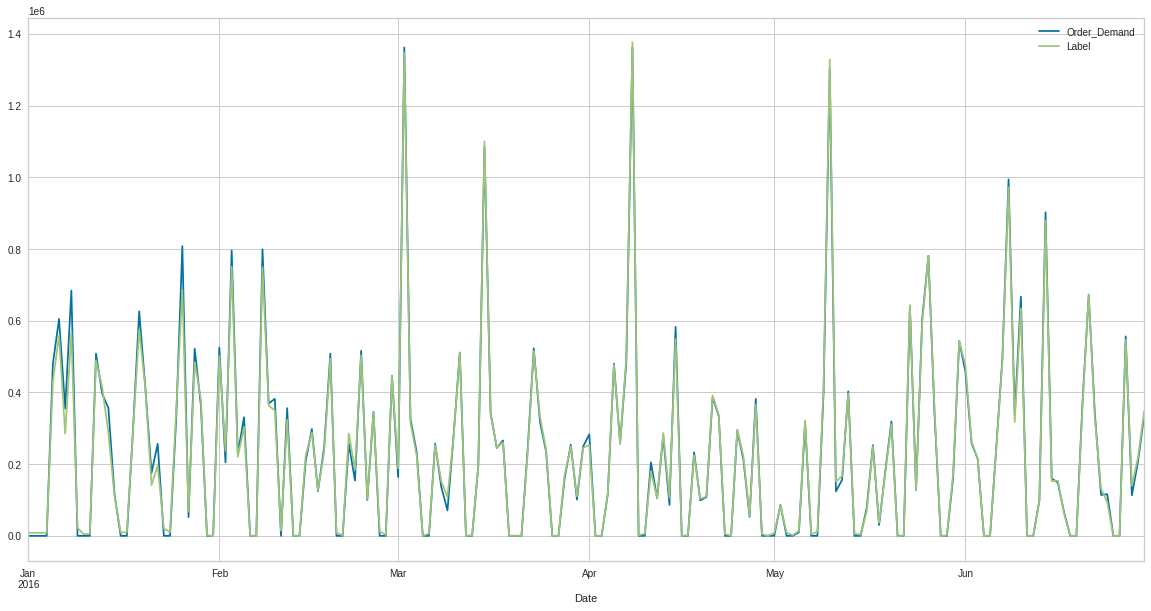

In [125]:
unseen_predictions_voting.plot(x='Date', y=['Order_Demand', 'Label'], figsize=(20,10), grid=True)

## 4.4 Saving the Model

In [127]:
save_model(final_voting,'Final Voting Model 1359 28 Jun 2021')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['month',
                                                             'day_of_week',
                                                             'day'],
                                       display_types=False,
                                       features_todrop=['Date'], id_columns=[],
                                       ml_usecase='regression',
                                       numerical_features=['day_of_year',
                                                           'year'],
                                       target='Order_Demand',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_...
                                                             subsample_for_bin=200000,
                                

## 4.5 Loading the Saved Model

In [128]:
saved_final_volting = load_model('Final Voting Model 1359 28 Jun 2021')

Transformation Pipeline and Model Successfully Loaded


In [129]:
new_prediction_voting = predict_model(saved_final_volting, data=test2)
new_prediction_voting.head()

,Date,Order_Demand,time_series,day,month,year,day_of_week,day_of_year,week,LAG2_Order_Demand,DIFF2_Order_Demand,ROLL_MEAN2_Order_Demand,ROLL_MAX2_Order_Demand,ROLL_MIN2_Order_Demand,DELTA_ROLL_MEAN2_Order_Demand,LAG4_Order_Demand,DIFF4_Order_Demand,ROLL_MEAN4_Order_Demand,ROLL_MAX4_Order_Demand,ROLL_MIN4_Order_Demand,DELTA_ROLL_MEAN4_Order_Demand,LAG7_Order_Demand,DIFF7_Order_Demand,ROLL_MEAN7_Order_Demand,ROLL_MAX7_Order_Demand,ROLL_MIN7_Order_Demand,DELTA_ROLL_MEAN7_Order_Demand,LAG15_Order_Demand,DIFF15_Order_Demand,ROLL_MEAN15_Order_Demand,ROLL_MAX15_Order_Demand,ROLL_MIN15_Order_Demand,DELTA_ROLL_MEAN15_Order_Demand,LAG30_Order_Demand,DIFF30_Order_Demand,ROLL_MEAN30_Order_Demand,ROLL_MAX30_Order_Demand,ROLL_MIN30_Order_Demand,DELTA_ROLL_MEAN30_Order_Demand,LAG60_Order_Demand,DIFF60_Order_Demand,ROLL_MEAN60_Order_Demand,ROLL_MAX60_Order_Demand,ROLL_MIN60_Order_Demand,DELTA_ROLL_MEAN60_Order_Demand,Label
3206273,2016-07-01,700000.0,warehouse_Whse_J_Product_CodeProduct_1359,1,7,2016,4,183,26,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,9875.527653
3206274,2016-07-02,0.0,warehouse_Whse_J_Product_CodeProduct_1359,2,7,2016,5,184,26,-1.0,-1.0,350000.0,700000.0,0.0,-350000.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,30454.259947
3206275,2016-07-03,0.0,warehouse_Whse_J_Product_CodeProduct_1359,3,7,2016,6,185,26,700000.0,-700000.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,9876.166434
3206276,2016-07-04,619000.0,warehouse_Whse_J_Product_CodeProduct_1359,4,7,2016,0,186,27,0.0,619000.0,309500.0,619000.0,0.0,309500.0,-1.0,-1.0,329750.0,700000.0,0.0,289250.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,428824.224401
3206277,2016-07-05,1115000.0,warehouse_Whse_J_Product_CodeProduct_1359,5,7,2016,1,187,27,0.0,1115000.0,867000.0,1115000.0,619000.0,248000.0,700000.0,415000.0,433500.0,1115000.0,0.0,681500.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,856021.064197


In [130]:
from pycaret.utils import check_metric
print(check_metric(new_prediction_voting.Order_Demand, new_prediction_voting.Label, 'R2'))
print(check_metric(new_prediction_voting.Order_Demand, new_prediction_voting.Label, 'MAE')) 

0.9576
19435.1251


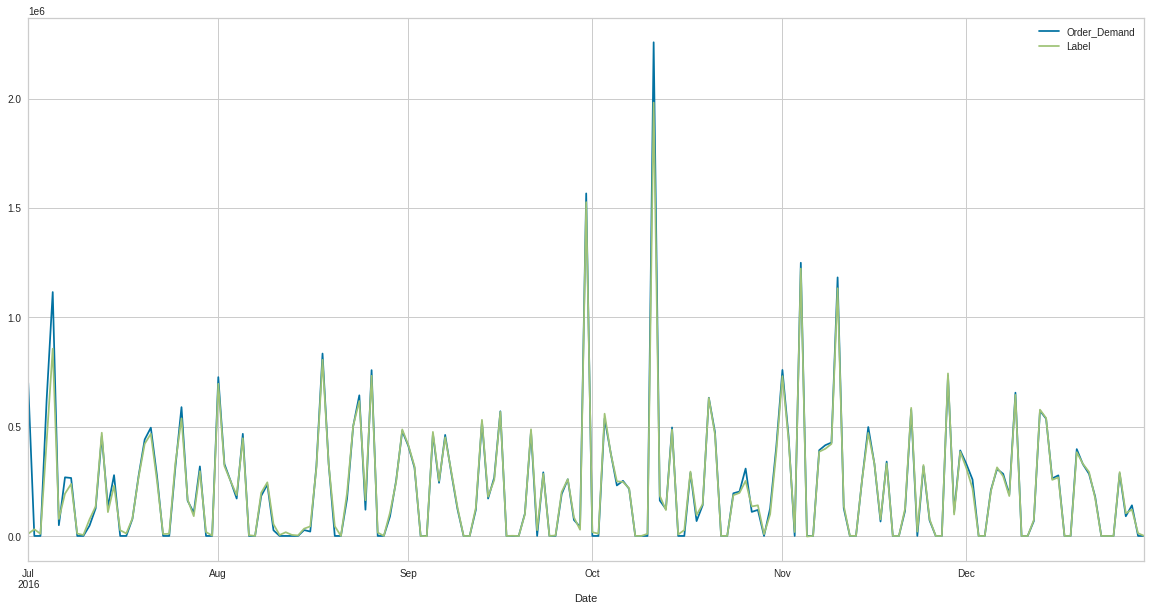

In [131]:
new_prediction_voting.plot(x='Date', y=['Order_Demand', 'Label'], figsize=(20,10), grid=True)